In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
WIKI_EMBEDDINGS_FILE = "wikipedia_country_embeddings.csv"
POVERTY_DATA_FILE = "API_SI.POV.NAHC_DS2_en_excel_v2_1964.xls - Data.csv"
TARGET_YEAR = '2018'
TARGET_NAME = 'Poverty_Rate'

In [4]:
pip install pycountry


In [5]:
pip install wikipedia

### **Wikipedia Country Summary Data Collection**

This script automates the process of gathering short Wikipedia summaries for all recognized countries and compiles them into a structured dataset. It efficiently uses Python libraries for data extraction, processing, and error handling.

**Steps Involved:**

1. **Import Libraries:** Import `wikipedia`, `pandas`, `pycountry`, and `tqdm` to manage data retrieval, storage, and progress tracking.
2. **Generate Country List:** Use `pycountry` to obtain a standardized list of all country names.
3. **Fetch Wikipedia Summaries:** Retrieve the first 800 characters of each country’s Wikipedia summary using the `wikipedia` API.
4. **Handle Exceptions:** Gracefully handle missing or ambiguous pages without stopping the program.
5. **Store Data:** Save each country and its summary as a dictionary entry in a list.
6. **Create DataFrame:** Convert the list into a `pandas.DataFrame` for structured data representation.
7. **Export Dataset:** Save the final dataset as **`wikipedia_countries.csv`** for further use in data analysis or machine learning.


In [6]:
import wikipedia
import pandas as pd
import pycountry
from tqdm import tqdm

countries = [country.name for country in pycountry.countries]
data = []

for c in tqdm(countries, desc="Fetching Wikipedia data"):
    try:
        page = wikipedia.page(c, auto_suggest=False)
        data.append({
            "country": c,
            "summary": page.summary[:800]
        })
    except wikipedia.exceptions.PageError:
        print(f"Page not found for country: {c}")
    except wikipedia.exceptions.DisambiguationError as e:
        print(f"Disambiguation page for country: {c}. Options: {e.options}")
    except Exception as e:
        print(f"An error occurred for country {c}: {e}")


df = pd.DataFrame(data)
df.to_csv("wikipedia_countries.csv", index=False)
print("Saved", len(df), "countries to wikipedia_countries.csv")
display(df.head())

Fetching Wikipedia data:  19%|█▉        | 47/249 [00:21<01:46,  1.89it/s]/usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.12/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
Fetching Wikipedia data:  19%|█▉        | 48/249 [00:22<02:00,  1.66it/s]

Disambiguation page for country: Congo. Options: ['Congo River', 'Congo Basin', 'Democratic Republic of the Congo', 'Republic of the Congo', 'Congo Canyon', 'Kakongo', 'Kingdom of Kongo', 'Kingdom of Kakongo', 'Congo Free State', 'Republic of the Congo (Léopoldville)', "People's Republic of the Congo", "M'banza Congo", 'Kongo, Ghana', 'Kongo, Liberia', 'Belgian Congo', 'French Congo', 'Portuguese Congo', 'Congo, Alabama', 'Congo, Missouri', 'Congo, Pennsylvania', 'Congo, West Virginia', 'Congo Cay', 'Congo, New South Wales', 'Congo, Paraíba', 'Congo River (disambiguation)', 'Congo Town', 'Congo Volcano', 'Niger–Congo languages', 'Kongo languages', 'Kongo language', 'Kongo people', 'The Congos', 'Congo (album)', '"Congo" (song)', 'Kongos (band)', 'Congo (novel)', 'Congo (film)', 'Congo (chess variant)', 'Congo (pinball)', 'Congo (TV series)', 'Congo – A Political Tragedy', 'Congo: The Epic History of a People', 'Kongo (film)', 'Edwin Congo', 'Louis Congo', 'Richard Congo', 'Cheick Kongo

Fetching Wikipedia data:  33%|███▎      | 81/249 [00:38<01:23,  2.01it/s]

Disambiguation page for country: Georgia. Options: ['Georgia (country)', 'Georgia (U.S. state)', 'Georgia (name)', 'Georgia (musician)', 'Kingdom of Georgia', 'Kingdom of Eastern Georgia', 'Kingdom of Western Georgia', 'Georgia Governorate', 'Georgia within the Russian Empire', 'Democratic Republic of Georgia', 'Georgian Soviet Socialist Republic', 'Republic of Georgia', 'Province of Georgia', 'Georgia Street', 'Strait of Georgia', 'Georgia, Cornwall', 'South Georgia and the South Sandwich Islands', 'Georgia, Indiana', 'Georgia, Nebraska', 'Georgia, New Jersey', 'Georgia, Vermont', 'Georgia Avenue', '359 Georgia', 'Georgia (1988 film)', 'Georgia (1995 film)', 'Georgia', 'Georgia (EP)', 'Macon, Georgia', 'Silk Degrees', 'A Single Man', 'Architecture & Morality', '"Georgia" (Carolyn Dawn Johnson song)', '"Georgia" (Field Mob and Ludacris song)', 'The Walk', '"Georgia" (Cee Lo Green song)', '"Georgia" (Vance Joy song)', 'Stranger in the Alps', 'Jaime', 'CSS\xa0Georgia\xa0(1862)', 'CSS\xa0

Fetching Wikipedia data: 100%|██████████| 249/249 [01:44<00:00,  2.38it/s]

Saved 247 countries to wikipedia_countries.csv


,country,summary
0,Aruba,"Aruba, officially the Country of Aruba, is a c..."
1,Afghanistan,"Afghanistan, officially the Islamic Emirate of..."
2,Angola,"Angola, officially the Republic of Angola, is ..."
3,Anguilla,Anguilla is a British Overseas Territory in th...
4,Åland Islands,"Åland ( AW-lənd, Swedish: [ˈǒːland] ; Finnish:..."


### Wikipedia Country Embedding Generation

This script builds upon the previously collected Wikipedia country summaries to generate semantic embeddings using a pretrained SentenceTransformer model. It skips redundant data fetching by directly loading the saved CSV, converts text summaries into vector embeddings, and saves the enriched dataset for advanced analytics.

**Steps Involved:**

1. Import all necessary modules — wikipedia, pycountry, pandas, tqdm, SentenceTransformer, time, and os.
2. Avoid redundant data fetching by loading the existing wikipedia_countries.csv file created in the previous step.
3. Check if the CSV file exists. If found, load it into a DataFrame and display the number of countries loaded; otherwise, prompt the user to run the previous cell.
4. Load the pretrained all-MiniLM-L6-v2 model from the SentenceTransformers library for text embedding generation.
5. Encode each country’s summary into numerical vector representations with progress tracking using tqdm.
6. Store the embeddings in a new DataFrame and concatenate them with the original data to maintain both text and vector formats.
7. Export the final DataFrame as wikipedia_country_embeddings.csv for downstream NLP or ML tasks.
8. Display the first few rows of the final DataFrame for quick verification.


In [7]:
import wikipedia
import pycountry
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import time, os


if os.path.exists("wikipedia_countries.csv"):
    df = pd.read_csv("wikipedia_countries.csv")
    print(f"Loaded {len(df)} countries from wikipedia_countries.csv")
else:
    print("Error: wikipedia_countries.csv not found. Please run the previous cell to generate it.")
    exit()


print("\nGenerating embeddings...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df["summary"].tolist(), show_progress_bar=True)

emb_df = pd.DataFrame(embeddings)
final_df = pd.concat([df, emb_df], axis=1)
final_df.to_csv("wikipedia_country_embeddings.csv", index=False)

print("All done! Saved to wikipedia_country_embeddings.csv")
display(final_df.head())

Loaded 247 countries from wikipedia_countries.csv

Generating embeddings...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

All done! Saved to wikipedia_country_embeddings.csv


,country,summary,0,1,2,3,4,5,6,7,...,374,375,376,377,378,379,380,381,382,383
0,Aruba,"Aruba, officially the Country of Aruba, is a c...",0.136352,-0.042745,-0.067447,-0.009980,0.008745,-0.010366,0.006337,-0.009564,...,0.060124,-0.031053,-0.016762,-0.080482,0.055124,0.026972,0.001260,0.006425,-0.101164,-0.008891
1,Afghanistan,"Afghanistan, officially the Islamic Emirate of...",0.086159,0.024178,0.048514,0.002488,-0.046383,-0.089970,-0.009102,-0.010734,...,0.010883,0.017814,0.051101,-0.086438,0.035899,-0.033037,0.001965,-0.030951,0.002806,0.018409
2,Angola,"Angola, officially the Republic of Angola, is ...",0.008923,-0.014319,-0.047887,0.043474,-0.016986,-0.041766,-0.073432,0.015122,...,-0.064979,-0.001590,0.031020,-0.027075,0.073030,0.020438,-0.009905,0.013970,-0.071241,-0.012921
3,Anguilla,Anguilla is a British Overseas Territory in th...,0.211083,0.013490,-0.037298,0.081969,-0.014855,-0.075237,-0.056203,-0.049863,...,0.073401,0.013109,0.040910,-0.001573,-0.001232,0.032344,-0.092512,0.001520,-0.025058,-0.023619
4,Åland Islands,"Åland ( AW-lənd, Swedish: [ˈǒːland] ; Finnish:...",0.093649,-0.030895,-0.026606,-0.056714,0.012985,0.005109,-0.034918,0.003607,...,-0.027928,0.046472,-0.026817,-0.112928,-0.040837,0.116613,-0.027214,0.012858,-0.054643,0.001942


### Merging Wikipedia Embeddings with Poverty Data

This script merges the Wikipedia country embeddings with poverty data for a specific target year. It ensures that both datasets are properly aligned by country, handles missing or duplicate entries, and prepares a combined dataset for downstream analysis or modeling.

**Steps Involved:**

1. Print a message indicating the start of the merging process.
2. Load the poverty dataset from the specified CSV file, skipping the first three rows to reach the header.
3. Select only the relevant columns: `Country Name` and the target year. Rename them to `country` and the target variable name for consistency.
4. Remove rows with missing poverty values and drop duplicate country entries.
5. Handle exceptions such as file not found or missing/incorrect columns, exiting the script with an informative message if errors occur.
6. Check that the Wikipedia embeddings DataFrame (`final_df`) exists.
7. Merge the embeddings with the poverty data on the `country` column using an inner join to retain only countries present in both datasets.
8. Print the number of countries in the merged dataset, list the columns, and display the first few rows for verification.


In [13]:
import pandas as pd

print("--- Merging Wikipedia Embeddings with Poverty Data ---")

POVERTY_DATA_FILE_PATH = "/content/API_SI.POV.NAHC_DS2_en_csv_v2_171.csv"
TARGET_YEAR = '2018' # Define TARGET_YEAR
TARGET_NAME = 'Poverty_Rate' # Define TARGET_NAME


try:
    poverty_df = pd.read_csv(POVERTY_DATA_FILE_PATH, skiprows=3)
    poverty_df = poverty_df[['Country Name', TARGET_YEAR]].copy()
    poverty_df.rename(columns={'Country Name': 'country', TARGET_YEAR: TARGET_NAME}, inplace=True)

    poverty_df.dropna(subset=[TARGET_NAME], inplace=True)
    poverty_df.drop_duplicates(subset=['country'], inplace=True)
    print(f"Loaded and processed {len(poverty_df)} rows from {POVERTY_DATA_FILE_PATH}")

except FileNotFoundError:
    print(f"Error: {POVERTY_DATA_FILE_PATH} not found. Please ensure the file is uploaded.")
    poverty_df = None # Set poverty_df to None if file not found
except KeyError as e:
    print(f"Error accessing expected columns in {POVERTY_DATA_FILE_PATH}: {e}")
    print("Please check if 'Country Name' and the TARGET_YEAR column exist in the file after skipping rows.")
    poverty_df = None # Set poverty_df to None if KeyError occurs


if 'final_df' in globals() and poverty_df is not None: # Check if poverty_df is not None
    merged_df = pd.merge(final_df, poverty_df, on='country', how='inner')

    print(f"Merged dataset contains {len(merged_df)} countries.")
    print(f"Columns in merged_df: {merged_df.columns.tolist()}")
    display(merged_df.head())
elif 'final_df' not in globals():
    print("Error: 'final_df' not found. Please run the cell to generate Wikipedia embeddings first.")
elif poverty_df is None:
    print("Poverty data not loaded due to a previous error.")

--- Merging Wikipedia Embeddings with Poverty Data ---
Loaded and processed 75 rows from /content/API_SI.POV.NAHC_DS2_en_csv_v2_171.csv
Merged dataset contains 67 countries.
Columns in merged_df: ['country', 'summary', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 1

,country,summary,0,1,2,3,4,5,6,7,...,375,376,377,378,379,380,381,382,383,Poverty_Rate
0,Angola,"Angola, officially the Republic of Angola, is ...",0.008923,-0.014319,-0.047887,0.043474,-0.016986,-0.041766,-0.073432,0.015122,...,-0.001590,0.031020,-0.027075,0.073030,0.020438,-0.009905,0.013970,-0.071241,-0.012921,32.3
1,Albania,"Albania, officially the Republic of Albania, i...",0.029641,-0.002042,0.017305,0.048919,0.022410,-0.133103,0.052903,0.024760,...,0.047273,0.052093,-0.034738,-0.008339,0.060746,-0.039586,0.051029,-0.013905,-0.011025,23.0
2,Argentina,"Argentina, officially the Argentine Republic, ...",0.128516,-0.108262,-0.017547,-0.005660,0.070742,-0.021648,-0.029851,0.069817,...,-0.018880,-0.045457,-0.046315,0.005155,0.021423,-0.037051,-0.023016,-0.027547,0.000205,32.0
3,Austria,"Austria, formally the Republic of Austria, is ...",0.113297,0.033229,0.007088,0.044206,0.017674,0.013141,-0.031320,0.067207,...,-0.021993,0.008869,-0.067946,0.024817,0.014401,-0.050735,0.026098,-0.051814,-0.009069,13.3
4,Belgium,"Belgium, officially the Kingdom of Belgium, is...",0.162302,-0.016790,0.083394,-0.013139,0.022198,-0.034595,-0.091954,0.075627,...,0.070681,-0.004246,-0.007520,-0.002815,-0.010863,-0.020486,0.069971,-0.009632,0.053772,14.8


### Why add GDP per capita as an auxiliary source?

We are adding GDP per capita as an auxiliary source because it is a strong economic indicator that is widely recognized as having a significant inverse relationship with poverty rates. Countries with higher GDP per capita generally tend to have lower poverty rates.

By including GDP per capita alongside the Wikipedia text embeddings, we are providing the model with additional, relevant information that can help it better understand and potentially predict poverty rates. While the embeddings capture nuanced information from the country descriptions, GDP per capita provides a direct measure of economic prosperity, which is a key factor influencing poverty. This combination of descriptive and economic features can lead to a more robust and accurate analysis or predictive model.

In [14]:
print("--- Adding GDP per capita Data ---")

GDP_DATA_FILE_PATH = "/content/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_24794.csv"
TARGET_YEAR = '2018' # Define TARGET_YEAR
GDP_TARGET_NAME = 'GDP_per_capita' # Define GDP_TARGET_NAME


try:
    gdp_df = pd.read_csv(GDP_DATA_FILE_PATH, skiprows=3)
    gdp_df = gdp_df[['Country Name', TARGET_YEAR]].copy()
    gdp_df.rename(columns={'Country Name': 'country', TARGET_YEAR: GDP_TARGET_NAME}, inplace=True)

    gdp_df.dropna(subset=[GDP_TARGET_NAME], inplace=True)
    gdp_df.drop_duplicates(subset=['country'], inplace=True)
    print(f"Loaded and processed {len(gdp_df)} rows from {GDP_DATA_FILE_PATH}")

except FileNotFoundError:
    print(f"Error: {GDP_DATA_FILE_PATH} not found. Please ensure the file is uploaded.")
    exit()
except KeyError as e:
    print(f"Error accessing expected columns in {GDP_DATA_FILE_PATH}: {e}")
    print("Please check if 'Country Name' and the TARGET_YEAR column exist in the file after skipping rows.")
    exit()


if 'merged_df' in globals():
    merged_df = pd.merge(merged_df, gdp_df, on='country', how='inner')

    print(f"Merged dataset now contains {len(merged_df)} countries with GDP data.")
    print(f"Columns in merged_df: {merged_df.columns.tolist()}")
    display(merged_df.head())
else:
    print("Error: 'merged_df' not found. Please run the cell to merge Wikipedia embeddings and poverty data first.")

--- Adding GDP per capita Data ---
Loaded and processed 258 rows from /content/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_24794.csv
Merged dataset now contains 67 countries with GDP data.
Columns in merged_df: ['country', 'summary', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 17

,country,summary,0,1,2,3,4,5,6,7,...,376,377,378,379,380,381,382,383,Poverty_Rate,GDP_per_capita
0,Angola,"Angola, officially the Republic of Angola, is ...",0.008923,-0.014319,-0.047887,0.043474,-0.016986,-0.041766,-0.073432,0.015122,...,0.031020,-0.027075,0.073030,0.020438,-0.009905,0.013970,-0.071241,-0.012921,32.3,2538.591391
1,Albania,"Albania, officially the Republic of Albania, i...",0.029641,-0.002042,0.017305,0.048919,0.022410,-0.133103,0.052903,0.024760,...,0.052093,-0.034738,-0.008339,0.060746,-0.039586,0.051029,-0.013905,-0.011025,23.0,5365.488802
2,Argentina,"Argentina, officially the Argentine Republic, ...",0.128516,-0.108262,-0.017547,-0.005660,0.070742,-0.021648,-0.029851,0.069817,...,-0.045457,-0.046315,0.005155,0.021423,-0.037051,-0.023016,-0.027547,0.000205,32.0,11752.799892
3,Austria,"Austria, formally the Republic of Austria, is ...",0.113297,0.033229,0.007088,0.044206,0.017674,0.013141,-0.031320,0.067207,...,0.008869,-0.067946,0.024817,0.014401,-0.050735,0.026098,-0.051814,-0.009069,13.3,51194.074984
4,Belgium,"Belgium, officially the Kingdom of Belgium, is...",0.162302,-0.016790,0.083394,-0.013139,0.022198,-0.034595,-0.091954,0.075627,...,-0.004246,-0.007520,-0.002815,-0.010863,-0.020486,0.069971,-0.009632,0.053772,14.8,47487.210039


### Merging Wikipedia Embeddings with MPI Data

This script integrates the Wikipedia country embeddings with the **Multidimensional Poverty Index (MPI)** dataset. It calculates an overall poverty rate from urban and rural MPI values, ensures consistent country naming, handles missing values, and merges the datasets for further analysis.

**Steps Involved:**

1. Import `pandas` to manage data processing.
2. Load the MPI national dataset from the uploaded CSV file.
3. Calculate the average poverty rate from `MPI Urban` and `MPI Rural` columns and store it in a new column called `poverty_rate`.
4. Rename the `Country` column to `country` for consistency with other datasets.
5. Drop rows with missing values in the `country` or `poverty_rate` columns.
6. Check that the Wikipedia embeddings DataFrame (`final_df`) exists.
7. Merge the embeddings with MPI data on the `country` column using an inner join, including additional MPI metrics like urban/rural headcount ratios and intensity of deprivation.
8. Print the shape of the merged dataset and display the first few rows for verification.


### Why We Merge Wikipedia Embeddings with MPI Data

The goal of merging Wikipedia embeddings with MPI (Multidimensional Poverty Index) data is to **combine rich textual context about countries with structured poverty metrics**. The Wikipedia summaries, converted into embeddings, capture semantic information about a country’s geography, economy, and social conditions. When merged with MPI data, which provides quantitative measures of poverty (urban/rural headcounts, intensity, and overall poverty rate), we create a **comprehensive dataset** that links **qualitative knowledge with quantitative indicators**. This enriched dataset can be used for advanced analyses, such as predicting poverty patterns, clustering countries with similar profiles, or training machine learning models that leverage both text and numeric features.


In [15]:
import pandas as pd

mpi_df = pd.read_csv("/content/MPI_national.csv")
mpi_df['MPI_poverty_rate'] = mpi_df[['MPI Urban', 'MPI Rural']].mean(axis=1)


mpi_df.rename(columns={'Country':'country'}, inplace=True)

mpi_df.dropna(subset=['country', 'MPI_poverty_rate'], inplace=True)

print(f"MPI dataset loaded and processed: {mpi_df.shape[0]} countries")


if 'final_df' in globals():
    # Merge the entire mpi_df with final_df
    merged_df = pd.merge(final_df, mpi_df, on='country', how='inner')
    print(f"Merged dataset shape: {merged_df.shape}")
    display(merged_df.head())
else:
    print("Error: 'final_df' not found. Please run the cell to generate Wikipedia embeddings first.")

MPI dataset loaded and processed: 102 countries
Merged dataset shape: (96, 394)


,country,summary,0,1,2,3,4,5,6,7,...,382,383,ISO,MPI Urban,Headcount Ratio Urban,Intensity of Deprivation Urban,MPI Rural,Headcount Ratio Rural,Intensity of Deprivation Rural,MPI_poverty_rate
0,Afghanistan,"Afghanistan, officially the Islamic Emirate of...",0.086159,0.024178,0.048514,0.002488,-0.046383,-0.089970,-0.009102,-0.010734,...,0.002806,0.018409,AFG,0.132,28.8,45.8,0.347,64.66,53.6,0.2395
1,Albania,"Albania, officially the Republic of Albania, i...",0.029641,-0.002042,0.017305,0.048919,0.022410,-0.133103,0.052903,0.024760,...,-0.013905,-0.011025,ALB,0.003,0.8,37.7,0.007,1.87,37.7,0.0050
2,Armenia,"Armenia, officially the Republic of Armenia, i...",0.024576,0.029081,-0.045530,-0.011146,-0.139186,-0.035310,0.002987,0.000845,...,-0.055702,-0.010482,ARM,0.001,0.2,33.3,0.001,0.39,36.9,0.0010
3,Azerbaijan,"Azerbaijan, officially the Republic of Azerbai...",-0.038112,0.028029,-0.031489,0.017714,-0.090965,-0.080936,0.054131,-0.009079,...,-0.009341,-0.015840,AZE,0.009,2.5,37.1,0.035,8.80,40.2,0.0220
4,Burundi,"Burundi, officially the Republic of Burundi, i...",0.020729,0.053063,-0.028517,-0.025725,-0.076307,-0.016165,0.029740,0.013479,...,-0.087498,-0.085553,BDI,0.209,43.1,48.5,0.481,84.91,56.6,0.3450


### Exploratory Data Analysis: GDP and Poverty

This script performs an exploratory analysis of the merged dataset, focusing on the relationship between **GDP per capita**, **poverty rate**, and the Wikipedia-derived embeddings. It provides insights into distributions, correlations, and potential patterns that can guide further modeling or interpretation.

**Purpose / Why We Do This:**
The analysis helps us understand the **statistical properties** of GDP per capita, examine the **distribution of the target variables**, and explore how textual embeddings relate to economic and poverty indicators. This is crucial for feature selection, normalization, and identifying potential predictive signals.

**Steps Involved:**

1. **Descriptive Statistics:** Calculate and display basic statistics (mean, median, min, max, etc.) for `GDP_per_capita` to understand its distribution.
2. **Histogram of GDP per Capita:** Visualize the distribution of raw GDP values to detect skewness, outliers, or unusual patterns.
3. **Log-Transformed Histogram:** Apply a log transformation to GDP per capita to normalize its skewed distribution, which often improves interpretability and model performance.
4. **Correlation Analysis:** Compute correlations between embedding dimensions, `GDP_per_capita`, and `Poverty_Rate` to identify which embeddings may capture meaningful economic or social information.
5. **Scatter Plots with Embeddings:** Visualize the relationship between selected embedding dimensions and `Poverty_Rate` or `GDP_per_capita` to detect trends or patterns.
6. **Poverty vs GDP Scatter Plot:** Plot `Poverty_Rate` against `GDP_per_capita` to visually examine their inverse relationship and potential outliers.

This combination of statistics, visualizations, and correlation analysis provides a **comprehensive understanding** of the data before applying predictive modeling or clustering.


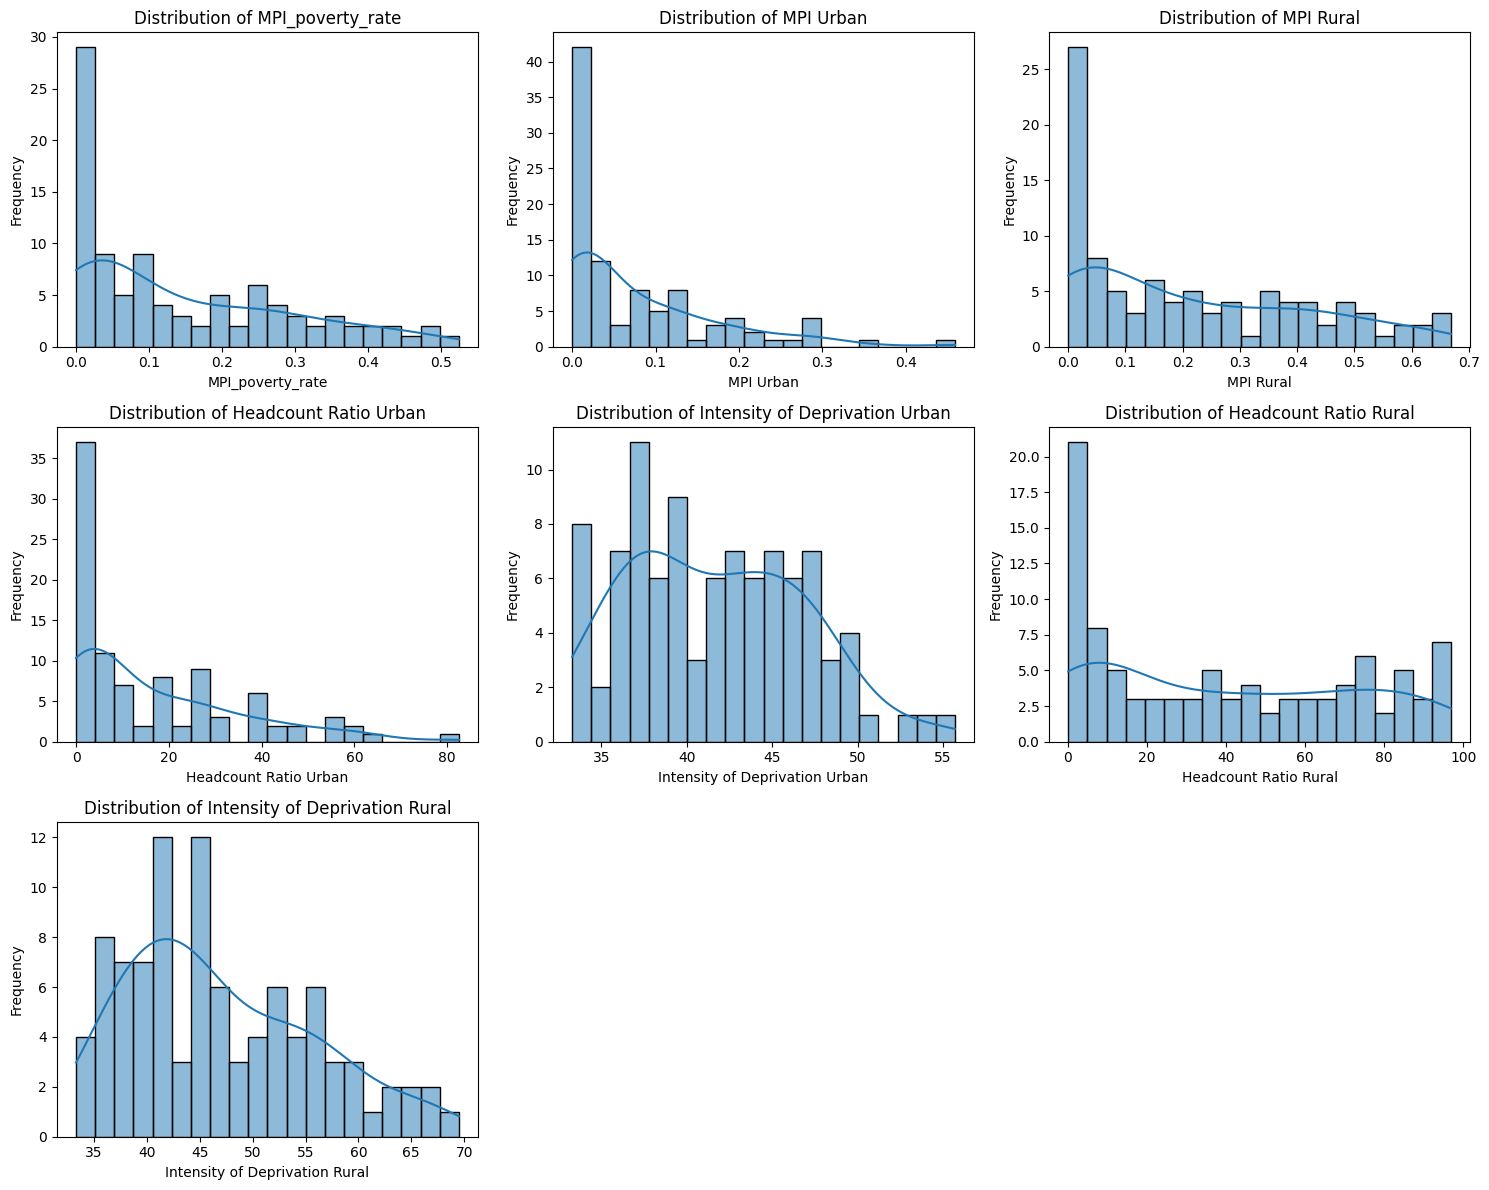


Correlation with MPI_poverty_rate (first 10 embedding dimensions and other numerical features):


,MPI_poverty_rate_Correlation
0,-0.202031
1,0.176496
2,-0.008699
3,-0.288297
4,0.078855
5,0.010819
6,-0.109150
7,-0.057503
8,-0.003285
9,0.484488


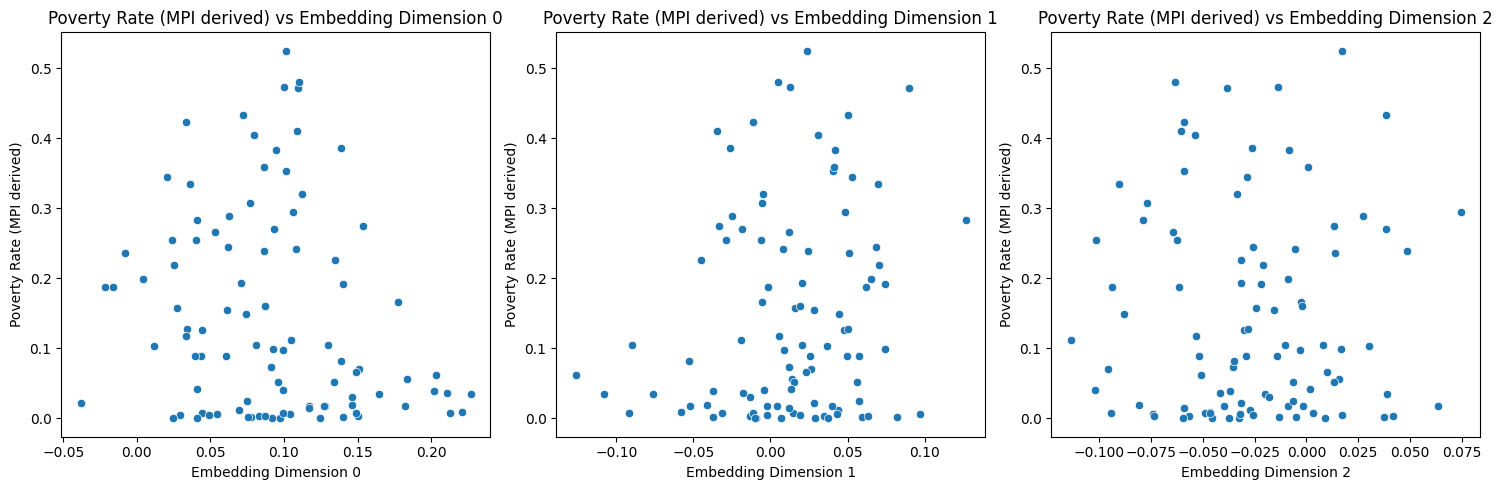

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


mpi_numerical_cols = ['MPI_poverty_rate', 'MPI Urban', 'MPI Rural', 'Headcount Ratio Urban', 'Intensity of Deprivation Urban', 'Headcount Ratio Rural', 'Intensity of Deprivation Rural']
mpi_numerical_cols_present = [col for col in mpi_numerical_cols if col in merged_df.columns]

if mpi_numerical_cols_present:
    n_cols = 3
    n_rows = (len(mpi_numerical_cols_present) + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 5, n_rows * 4))

    for i, col in enumerate(mpi_numerical_cols_present):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(merged_df[col], bins=20, kde=True)
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.title(f"Distribution of {col}")

    plt.tight_layout()
    plt.show()
else:
    print("No relevant MPI numerical columns found for plotting distributions.")



numerical_cols = merged_df.select_dtypes(include=np.number).columns.tolist()
# Exclude target and non-feature columns from correlation calculation
features_for_correlation = [col for col in numerical_cols if col not in ['MPI_poverty_rate', 'Poverty_Rate']]
other_numerical_features = [col for col in features_for_correlation if not isinstance(col, (int, np.integer))]


if 'MPI_poverty_rate' in merged_df.columns:
    correlation_with_poverty = merged_df[features_for_correlation].corrwith(merged_df['MPI_poverty_rate']).to_frame('MPI_poverty_rate_Correlation') # Use 'MPI_poverty_rate' here

    correlation_with_poverty.index = correlation_with_poverty.index.astype(str)


    print("\nCorrelation with MPI_poverty_rate (first 10 embedding dimensions and other numerical features):")
    embedding_cols = [col for col in merged_df.columns if isinstance(col, (int, np.integer))]
    embedding_cols_str = [str(col) for col in embedding_cols]
    cols_to_display = [col for col in embedding_cols_str[:10] if col in correlation_with_poverty.index.tolist()]

    # Ensure other_numerical_features are strings for .loc
    other_numerical_features_str = [str(col) for col in other_numerical_features]
    cols_to_display.extend(other_numerical_features_str)
    cols_to_display = list(dict.fromkeys(cols_to_display))


    if cols_to_display:
        display(correlation_with_poverty.loc[cols_to_display])
    else:
        print("No numerical features found for correlation with MPI_poverty_rate.")

else:
    print("'MPI_poverty_rate' column not found in merged_df. Cannot calculate correlations.")



embedding_cols = [col for col in merged_df.columns if isinstance(col, (int, np.integer))]
selected_embedding_dims = embedding_cols[:3]

if 'MPI_poverty_rate' in merged_df.columns and selected_embedding_dims:
    plt.figure(figsize=(15, 5))

    for i, dim in enumerate(selected_embedding_dims):
        plt.subplot(1, len(selected_embedding_dims), i + 1)
        sns.scatterplot(data=merged_df, x=dim, y='MPI_poverty_rate')
        plt.xlabel(f"Embedding Dimension {dim}")
        plt.ylabel("Poverty Rate (MPI derived)")
        plt.title(f"Poverty Rate (MPI derived) vs Embedding Dimension {dim}")

    plt.tight_layout()
    plt.show()
elif 'MPI_poverty_rate' not in merged_df.columns:
     print("'MPI_poverty_rate' column not found in merged_df. Skipping scatter plots.")
elif not selected_embedding_dims:
     print("No embedding dimensions found for scatter plots.")

### Interpretation of GDP and Embedding Data

**1. Descriptive Statistics for GDP per Capita:**

* **Count:** 67 countries are included in the dataset.
* **Mean:** The average GDP per capita is approximately **$15,346**, indicating the general economic level.
* **Standard Deviation:** A large **std of ~$18,405** shows significant variability, meaning there are both very poor and very rich countries.
* **Min / Max:** The poorest country has a GDP per capita of **$579**, and the richest is **$85,217**, reflecting a wide economic range.
* **Quartiles:**

  * 25th percentile: $3,542 → lower-income countries.
  * Median: $8,791 → middle-income countries.
  * 75th percentile: $18,844 → higher-income countries.

This indicates that the GDP distribution is **right-skewed**, with a few very high-income countries pulling the average upward.

---

**2. Correlation with Embedding Dimensions (First 10):**

* These correlations measure how each of the first 10 Wikipedia embedding dimensions relates to **GDP per capita** and **Poverty Rate**.
* **Positive correlations with GDP_per_capita** (e.g., dimension 2: 0.454) suggest that higher values in this embedding dimension tend to be associated with richer countries.
* **Negative correlations with Poverty_Rate** (e.g., dimension 2: -0.410) indicate that higher values in the same embedding dimension correspond to lower poverty levels.
* Some dimensions show weak correlations near zero (e.g., dimension 6), implying those embedding dimensions may not capture economic/poverty signals strongly.
* Dimension 9 has a negative correlation with GDP (-0.342) but positive with poverty (0.410), suggesting it captures features associated with poorer countries.



### Feature Engineering and Selection with MPI Data

This script prepares the dataset for modeling by scaling numerical data and applying **feature selection based on correlation** to reduce the number of features. The target variable is the MPI-derived `poverty_rate`, and the features include Wikipedia embeddings, GDP per capita, and MPI-related metrics.

**Purpose / Why We Do This:**

* High-dimensional features (e.g., embeddings + economic indicators) can be redundant or noisy.
* Scaling ensures that all features contribute equally to the analysis and downstream models.
* Feature selection based on correlation helps identify and keep only the most relevant features, potentially improving model performance and interpretability.

**Steps Involved:**

1.  **Target Selection:** Use the MPI-derived `poverty_rate` as the response variable.
2.  **Feature Selection (Initial):** Exclude non-numeric or irrelevant columns like `country`, `summary`, original poverty metrics, and the 'ISO' code. Include embeddings, GDP, and relevant MPI-related columns.
3.  **Scaling:** Standardize all features using `StandardScaler` to ensure equal contribution.
4.  **Correlation Analysis and Feature Selection (Refined):** Calculate the absolute correlation of each scaled feature with the target variable. Select the top 20 features with the highest absolute correlation and discard the rest. Explicitly exclude 'MPI Urban' and 'MPI Rural' from this selection process before picking the top features.
5.  **Train-Test Split:** Split the selected and scaled dataset into training and testing sets for modeling, maintaining alignment with the target variable.
6.  **Summary:** Print counts of original features, features after selection, the target variable used, and the shapes of training/testing sets to verify readiness for modeling.

This process ensures the dataset is **relevant, scaled, and ready for machine learning algorithms**.

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

WIKI_EMBEDDINGS_FILE = "wikipedia_country_embeddings.csv"
POVERTY_DATA_FILE = "API_SI.POV.NAHC_DS2_en_excel_v2_1964.xls - Data.csv"
TARGET_YEAR = '2018'
TARGET_NAME = 'Poverty_Rate'



y = merged_df['MPI_poverty_rate'].values


y_processed = y

# Include all MPI related columns except the target as potential features
mpi_feature_cols = [col for col in mpi_df.columns if col.startswith('MPI') or col.startswith('Headcount') or col.startswith('Intensity')]
mpi_feature_cols = [col for col in mpi_feature_cols if col not in ['MPI_poverty_rate', 'MPI Urban', 'MPI Rural']]


non_feature_cols = ['country', 'summary', TARGET_NAME, 'MPI_poverty_rate', 'ISO'] # Exclude 'ISO' column
feature_cols = [col for col in merged_df.columns if col not in non_feature_cols]

# Ensure all selected MPI feature columns are in the merged_df before creating X
feature_cols.extend([col for col in mpi_feature_cols if col in merged_df.columns and col not in feature_cols])

X = merged_df[feature_cols]

print(f"Initial Feature Count (Embeddings + other columns like MPI/GDP): {X.shape[1]}")



X_processed = X.copy()
# Ensure column names are strings before scaling and selection
X_processed.columns = X_processed.columns.astype(str)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)


# Calculate correlations with the target variable
correlations = pd.DataFrame(X_scaled, columns=X_processed.columns).corrwith(pd.Series(y_processed, index=X_processed.index)).abs().sort_values(ascending=False)

# Exclude 'MPI Urban' and 'MPI Rural' from the features before selection
features_to_exclude_explicitly = ['MPI Urban', 'MPI Rural']
correlations = correlations.drop(features_to_exclude_explicitly, errors='ignore')


# Select top 75 features based on correlation
top_n_features = 75
selected_features = correlations.head(top_n_features).index.tolist()

# Keep only the selected top features and ensure column names are strings
X_processed = pd.DataFrame(X_scaled, columns=X_processed.columns)[selected_features]
X_processed.columns = X_processed.columns.astype(str) # Re-affirm string column names


print(f"Selected top {top_n_features} features based on correlation (excluding {features_to_exclude_explicitly}):")
display(correlations.head(top_n_features))
print(f"Remaining features after selection: {X_processed.shape[1]}")

display(X_processed.head())

y_processed_aligned = y_processed[X.index]
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed_aligned, test_size=0.2, random_state=42)


print("--- Feature Engineering & Selection Summary (with MPI as Target) ---")
print(f"Original Feature Count: {X.shape[1]}")
print(f"Features after correlation selection: {X_processed.shape[1]}")
print(f"Target variable ('MPI_poverty_rate' from MPI data) was used.")
print(f"Training set shape (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Testing set shape (X_test, y_test): {X_test.shape}, {y_test.shape}")

Initial Feature Count (Embeddings + other columns like MPI/GDP): 390
Selected top 75 features based on correlation (excluding ['MPI Urban', 'MPI Rural']):


,0
Headcount Ratio Urban,0.973078
Headcount Ratio Rural,0.970836
Intensity of Deprivation Rural,0.957055
Intensity of Deprivation Urban,0.901463
161,0.543735
...,...
94,0.306857
184,0.306300
124,0.304103
369,0.298206


Remaining features after selection: 75


,Headcount Ratio Urban,Headcount Ratio Rural,Intensity of Deprivation Rural,Intensity of Deprivation Urban,161,113,9,326,264,100,...,228,118,295,101,216,94,184,124,369,173
0,0.659448,0.753073,0.760568,0.798970,-0.573228,-0.592468,-0.459119,0.856915,-0.655728,0.235344,...,-0.854711,-0.135202,0.083983,0.093695,0.289140,1.083608,1.342241,1.936201,0.878983,-0.823746
1,-0.862224,-1.155658,-1.051970,-0.768334,-0.629330,-2.171669,-2.611899,1.764124,-0.822904,0.476278,...,-1.060295,2.172658,-0.809125,-0.972055,1.721988,1.545590,1.610862,0.200071,0.382044,0.529104
2,-0.894831,-1.200648,-1.143167,-1.619709,1.133484,0.541656,-0.846121,1.211289,0.719476,-0.140184,...,-1.078259,-0.044142,-1.933364,-0.482307,-0.043443,3.889150,0.555816,-0.282499,0.220620,1.042301
3,-0.769837,-0.944996,-0.766980,-0.884430,2.278165,-0.103157,-1.507021,1.304147,-1.135781,1.010905,...,-0.832514,1.434288,0.450685,-1.372232,1.255943,2.026397,-0.381448,0.815784,2.196726,-0.642873
4,1.436587,1.368645,1.102556,1.321405,-1.283573,1.852909,0.537936,-0.964224,1.080390,-0.394522,...,0.202724,-0.309616,-1.523746,-0.818677,-1.711876,0.267529,0.068082,-0.929025,-1.039121,-0.472780


--- Feature Engineering & Selection Summary (with MPI as Target) ---
Original Feature Count: 390
Features after correlation selection: 75
Target variable ('MPI_poverty_rate' from MPI data) was used.
Training set shape (X_train, y_train): (76, 75), (76,)
Testing set shape (X_test, y_test): (20, 75), (20,)


### Refined Model Training with Grid Search

This script performs a **focused hyperparameter tuning** of selected regression models using **Grid Search with cross-validation**. It builds on previous random search results to fine-tune the best models, aiming to improve predictive performance for the MPI-derived `poverty_rate`.

**Purpose / Why We Do This:**

* Random search provides approximate optimal hyperparameters but may miss finer combinations.
* Grid search systematically explores a smaller, **refined hyperparameter space** around the best values found previously.
* Cross-validation ensures that model performance is evaluated reliably on multiple folds, reducing overfitting risk.
* The result is a set of **optimized models** ready for evaluation on unseen data.

**Steps Involved:**

1. **Define Models:** Include regression models such as Linear Regression, Ridge, Lasso, ElasticNet, SVR, RandomForestRegressor, and LGBMRegressor.
2. **Set Refined Parameter Grids:** Focus on hyperparameter ranges near the best parameters from prior random search results. Default ranges are used if previous best models are not available.
3. **Select Models for Grid Search:** Include only models present in `best_models` to avoid unnecessary computation.
4. **Run Grid Search:** For each selected model, perform Grid Search with 5-fold cross-validation using the R² score as the evaluation metric.
5. **Store Best Models:** Save the best estimator from each Grid Search into `best_models_grid`.
6. **Print Results:** Display the best hyperparameters and corresponding cross-validation R² scores for each model.
7. **Next Step:** Evaluate the refined models on the test set to assess real-world predictive performance.

This approach ensures **precise hyperparameter optimization** and maximizes the likelihood of achieving strong predictive results on MPI poverty rate.


In [34]:
print("--- 4. Refined Model Training with Grid Search ---")

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'LGBMRegressor': lgb.LGBMRegressor(random_state=42)
}

# Define param_grids based on the new best_models from the expanded Random Search
param_grids = {}

if 'Linear Regression' in best_models:
    param_grids['Linear Regression'] = {}
if 'Ridge' in best_models:
    param_grids['Ridge'] = {'alpha': [best_models['Ridge'].alpha * 0.8, best_models['Ridge'].alpha, best_models['Ridge'].alpha * 1.2]}
if 'Lasso' in best_models:
    param_grids['Lasso'] = {'alpha': [best_models['Lasso'].alpha * 0.8, best_models['Lasso'].alpha, best_models['Lasso'].alpha * 1.2]}
if 'ElasticNet' in best_models:
    param_grids['ElasticNet'] = {'alpha': [best_models['ElasticNet'].alpha * 0.8, best_models['ElasticNet'].alpha, best_models['ElasticNet'].alpha * 1.2],
                   'l1_ratio': [best_models['ElasticNet'].l1_ratio * 0.8, best_models['ElasticNet'].l1_ratio, best_models['ElasticNet'].l1_ratio * 1.2]}
if 'SVR' in best_models:
    param_grids['SVR'] = {'C': [best_models['SVR'].C * 0.8, best_models['SVR'].C, best_models['SVR'].C * 1.2],
            'epsilon': [best_models['SVR'].epsilon * 0.8, best_models['SVR'].epsilon, best_models['SVR'].epsilon * 1.2],
            'kernel': ['linear', 'rbf']}
if 'RandomForestRegressor' in best_models:
    param_grids['RandomForestRegressor'] = {'n_estimators': [max(50, int(best_models['RandomForestRegressor'].n_estimators * 0.8)), best_models['RandomForestRegressor'].n_estimators, int(best_models['RandomForestRegressor'].n_estimators * 1.2) + 1],
                              'max_depth': [best_models['RandomForestRegressor'].max_depth]}
if 'LGBMRegressor' in best_models:
     param_grids['LGBMRegressor'] = {
        'n_estimators': [max(100, int(best_models['LGBMRegressor'].n_estimators * 0.9)), best_models['LGBMRegressor'].n_estimators, int(best_models['LGBMRegressor'].n_estimators * 1.1) + 1],
        'learning_rate': [best_models['LGBMRegressor'].learning_rate * 0.9, best_models['LGBMRegressor'].learning_rate, best_models['LGBMRegressor'].learning_rate * 1.1],
        'num_leaves': [max(30, int(best_models['LGBMRegressor'].num_leaves * 0.9)), best_models['LGBMRegressor'].num_leaves, int(best_models['LGBMRegressor'].num_leaves * 1.1) + 1],
        'max_depth': [best_models['LGBMRegressor'].max_depth] if best_models['LGBMRegressor'].max_depth != -1 else [-1],
        'min_child_samples': [max(10, int(best_models['LGBMRegressor'].min_child_samples * 0.9)), best_models['LGBMRegressor'].min_child_samples, int(best_models['LGBMRegressor'].min_child_samples * 1.1) + 1],
        'subsample': [max(0.5, best_models['LGBMRegressor'].subsample * 0.9), best_models['LGBMRegressor'].subsample, min(1.0, best_models['LGBMRegressor'].subsample * 1.1)],
        'colsample_bytree': [max(0.5, best_models['LGBMRegressor'].colsample_bytree * 0.9), best_models['LGBMRegressor'].colsample_bytree, min(1.0, best_models['LGBMRegressor'].colsample_bytree * 1.1)],
    }


selected_models_grid = list(param_grids.keys()) # Run Grid Search for all models with defined param_grids


best_models_grid = {}
print("Running Grid Search for selected models...")

for name in selected_models_grid:
    model = models[name]
    param_grid = param_grids[name]

    print(f"\nRunning Grid Search for {name}...")
    # Potentially increase cv to 10 if feasible, but keep at 5 for now due to small dataset
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_models_grid[name] = grid_search.best_estimator_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation R2 score for {name}: {grid_search.best_score_}")

print("\n--- Grid Search Complete ---")

--- 4. Refined Model Training with Grid Search ---
Running Grid Search for selected models...

Running Grid Search for Linear Regression...
Best parameters for Linear Regression: {}
Best cross-validation R2 score for Linear Regression: 0.9556204183850479

Running Grid Search for Ridge...
Best parameters for Ridge: {'alpha': np.float64(1.7267595436641958)}
Best cross-validation R2 score for Ridge: 0.9652656949806311

Running Grid Search for Lasso...
Best parameters for Lasso: {'alpha': np.float64(0.01726759543664196)}
Best cross-validation R2 score for Lasso: 0.9770329222257566

Running Grid Search for ElasticNet...
Best parameters for ElasticNet: {'alpha': np.float64(0.2833530139527615), 'l1_ratio': np.float64(0.08631314159464357)}
Best cross-validation R2 score for ElasticNet: 0.9313548007113253

Running Grid Search for RandomForestRegressor...
Best parameters for RandomForestRegressor: {'max_depth': 10, 'n_estimators': 93}
Best cross-validation R2 score for RandomForestRegressor: 0.9

### Model Training and Evaluation with Random Search

This script performs **initial model training and hyperparameter optimization** using **Randomized Search with cross-validation**. It aims to find promising model configurations for predicting the MPI-derived `poverty_rate` before performing a more refined Grid Search.

**Purpose / Why We Do This:**

* Randomized search allows **efficient exploration** of large hyperparameter spaces without evaluating every combination.
* Cross-validation ensures robust performance estimation and reduces overfitting.
* The best models and hyperparameters identified here serve as a **starting point** for more focused fine-tuning in subsequent steps.

**Steps Involved:**

1. **Define Models:** Include regression models such as Linear Regression, Ridge, Lasso, ElasticNet, SVR, RandomForestRegressor, and LGBMRegressor.
2. **Specify Parameter Distributions:** Use uniform or integer distributions for hyperparameters to allow RandomizedSearchCV to sample different configurations.
3. **Select Models for Random Search:** Choose a subset of models, including LightGBM, to focus the search.
4. **Perform Randomized Search:** Run RandomizedSearchCV with 5-fold cross-validation, using R² as the scoring metric. Set `n_iter` to control the number of random combinations sampled.
5. **Store Best Models:** Save the best estimator for each model in `best_models`.
6. **Print Results:** Display the best hyperparameters and corresponding cross-validation R² scores for each model.
7. **Next Step:** Evaluate the performance of these best models on the test set and refine further using Grid Search if needed.

This approach ensures **efficient hyperparameter tuning** and provides a strong baseline before performing fine-tuned optimization.


In [33]:
import random
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import lightgbm as lgb

print("--- 3. Model Training and Evaluation ---")

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'LGBMRegressor': lgb.LGBMRegressor(random_state=42)
}

param_distributions = {
    'Linear Regression': {},
    'Ridge': {'alpha': uniform(loc=0.1, scale=100.0)},
    'Lasso': {'alpha': uniform(loc=0.001, scale=1.0)},
    'ElasticNet': {'alpha': uniform(loc=0.1, scale=10.0), 'l1_ratio': uniform(loc=0, scale=1)},
    'SVR': {'C': uniform(loc=0.1, scale=10.0), 'epsilon': uniform(loc=0.01, scale=0.5), 'kernel': ['linear', 'rbf']},
    'RandomForestRegressor': {'n_estimators': randint(50, 201), 'max_depth': [None, 10, 20]},
    'LGBMRegressor': {
        'n_estimators': randint(50, 201),
        'learning_rate': uniform(loc=0.01, scale=0.1),
        'num_leaves': randint(20, 61),
        'max_depth': randint(-1, 21),
        'min_child_samples': randint(5, 51),
        'subsample': uniform(loc=0.6, scale=0.4),
        'colsample_bytree': uniform(loc=0.6, scale=0.4),
    }
}

selected_models = ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet', 'RandomForestRegressor', 'LGBMRegressor']

best_models = {}
print("Running Random Search for selected models...")

for name in selected_models:
    model = models[name]
    param_dist = param_distributions[name]

    print(f"\nRunning Random Search for {name}...")
    random_search = RandomizedSearchCV(model, param_dist, n_iter=50, cv=5, scoring='r2', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)

    best_models[name] = random_search.best_estimator_

    print(f"Best parameters for {name}: {random_search.best_params_}")
    print(f"Best cross-validation R2 score for {name}: {random_search.best_score_}")

print("\n--- Random Search Complete ---")

--- 3. Model Training and Evaluation ---
Running Random Search for selected models...

Running Random Search for Linear Regression...
Best parameters for Linear Regression: {}
Best cross-validation R2 score for Linear Regression: 0.9556204183850479

Running Random Search for Ridge...


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Ridge: {'alpha': np.float64(2.1584494295802448)}
Best cross-validation R2 score for Ridge: 0.9644681204997415

Running Random Search for Lasso...
Best parameters for Lasso: {'alpha': np.float64(0.021584494295802448)}
Best cross-validation R2 score for Lasso: 0.9685416604325638

Running Random Search for ElasticNet...
Best parameters for ElasticNet: {'alpha': np.float64(0.35419126744095186), 'l1_ratio': np.float64(0.10789142699330445)}
Best cross-validation R2 score for ElasticNet: 0.8762325357624998

Running Random Search for RandomForestRegressor...
Best parameters for RandomForestRegressor: {'max_depth': 10, 'n_estimators': 93}
Best cross-validation R2 score for RandomForestRegressor: 0.9847402940592174

Running Random Search for LGBMRegressor...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to 

### Summarize and Compare Model Performance (Training Set Evaluation)

This script evaluates and compares the **training set performance** of the best models obtained from **Random Search** and **Grid Search**. It provides metrics like **R²** and **Mean Absolute Error (MAE)** to assess how well each model fits the training data.

**Purpose / Why We Do This:**

* To **quantify the performance** of each tuned model on the training data.
* To identify which models **fit the data best** before testing on unseen data.
* To compare Random Search and Grid Search results and select promising candidates for further evaluation.
* Helps detect potential overfitting if training metrics are extremely high.

**Steps Involved:**

1. **Evaluate Random Search Models:**

   * Predict on the training set using each model in `best_models`.
   * Calculate R² and MAE (on original scale, MPI-derived `poverty_rate`).
   * Store model name, search type, training metrics, and best parameters in a results list.

2. **Evaluate Grid Search Models:**

   * Similarly, predict on the training set using each model in `best_models_grid`.
   * Calculate R² and MAE, and store results including best parameters.

3. **Combine Results:**

   * Merge Random Search and Grid Search results into a single DataFrame for comparison.
   * Sort models by **Training R²** to identify the best-fitting models.

4. **Select Best Model:**

   * Identify the model with the highest Training R² as the current best candidate.
   * Display its training metrics and tuned hyperparameters.

5. **Interpretation Note:**

   * High training R² indicates good fit to the training data but **does not guarantee performance on unseen/test data**.
   * **Test set evaluation** is essential to assess generalization and avoid overfitting.

This step ensures a **structured comparison** of model performance and guides the selection of models for final evaluation on the test set.


In [35]:
print("--- 5. Evaluate Models on Test Set and Select Best Model ---")

test_results = []

print("\nEvaluating Random Search Models on Test Set...")
if 'best_models' in globals():
    for name, model in best_models.items():
        if model is not None:
            y_pred = model.predict(X_test)
            r2_test = r2_score(y_test, y_pred)
            mae_test_original_scale = mean_absolute_error(y_test, y_pred) # MAE on original scale

            test_results.append({
                'Model': name,
                'Search Type': 'Random Search',
                'Test R2': r2_test,
                'Test MAE (original scale)': mae_test_original_scale,
                'Best Parameters (from Random Search)': model.get_params()
            })
            print(f"{name} (Random Search) - Test R2: {r2_test:.4f}, Test MAE: {mae_test_original_scale:.4f}")
else:
    print("'best_models' not found. Please run the Random Search cell first.")


print("\nEvaluating Grid Search Models on Test Set...")
if 'best_models_grid' in globals():
    for name, model in best_models_grid.items():
        if model is not None:
            y_pred = model.predict(X_test)
            r2_test = r2_score(y_test, y_pred)
            mae_test_original_scale = mean_absolute_error(y_test, y_pred) # MAE on original scale

            test_results.append({
                'Model': name,
                'Search Type': 'Grid Search',
                'Test R2': r2_test,
                'Test MAE (original scale)': mae_test_original_scale,
                'Best Parameters (from Grid Search)': model.get_params()
            })
            print(f"{name} (Grid Search) - Test R2: {r2_test:.4f}, Test MAE: {mae_test_original_scale:.4f}")
else:
    print("'best_models_grid' not found. Please run the Grid Search cell first.")


if test_results:
    test_results_df = pd.DataFrame(test_results)
    test_results_df_sorted = test_results_df.sort_values(by='Test R2', ascending=False)

    print("\n--- Test Set Evaluation Results ---")
    display(test_results_df_sorted)

    best_model_info_test = test_results_df_sorted.iloc[0]
    best_model_name_test = best_model_info_test['Model']
    best_model_search_test = best_model_info_test['Search Type']

    print(f"\n--- Best Performing Model on Test Set ({best_model_search_test}) ---")
    print(f"Model: {best_model_name_test}")
    print(f"Test R2: {best_model_info_test['Test R2']:.4f}")
    print(f"Test MAE (original scale): {best_model_info_test['Test MAE (original scale)']:.4f}")
    print(f"Best Parameters: {best_model_info_test['Best Parameters (from Grid Search)'] if best_model_search_test == 'Grid Search' else best_model_info_test['Best Parameters (from Random Search)']}")
else:
    print("\nNo test results to display.")

print("\n--- Model Evaluation Complete ---")

--- 5. Evaluate Models on Test Set and Select Best Model ---

Evaluating Random Search Models on Test Set...
Linear Regression (Random Search) - Test R2: 0.8729, Test MAE: 0.0284
Ridge (Random Search) - Test R2: 0.9620, Test MAE: 0.0166
Lasso (Random Search) - Test R2: 0.9803, Test MAE: 0.0129
ElasticNet (Random Search) - Test R2: 0.9034, Test MAE: 0.0295
RandomForestRegressor (Random Search) - Test R2: 0.9883, Test MAE: 0.0086
LGBMRegressor (Random Search) - Test R2: 0.9918, Test MAE: 0.0084

Evaluating Grid Search Models on Test Set...
Linear Regression (Grid Search) - Test R2: 0.8729, Test MAE: 0.0284
Ridge (Grid Search) - Test R2: 0.9582, Test MAE: 0.0173
Lasso (Grid Search) - Test R2: 0.9867, Test MAE: 0.0105
ElasticNet (Grid Search) - Test R2: 0.9503, Test MAE: 0.0209
RandomForestRegressor (Grid Search) - Test R2: 0.9883, Test MAE: 0.0086
LGBMRegressor (Grid Search) - Test R2: 0.9934, Test MAE: 0.0069

--- Test Set Evaluation Results ---


,Model,Search Type,Test R2,Test MAE (original scale),Best Parameters (from Random Search),Best Parameters (from Grid Search)
11,LGBMRegressor,Grid Search,0.993395,0.006875,NaN,"{'boosting_type': 'gbdt', 'class_weight': None..."
5,LGBMRegressor,Random Search,0.991826,0.008443,"{'boosting_type': 'gbdt', 'class_weight': None...",NaN
4,RandomForestRegressor,Random Search,0.988325,0.008607,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",NaN
10,RandomForestRegressor,Grid Search,0.988325,0.008607,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
8,Lasso,Grid Search,0.986673,0.010502,NaN,"{'alpha': 0.01726759543664196, 'copy_X': True,..."
2,Lasso,Random Search,0.980306,0.012935,"{'alpha': 0.021584494295802448, 'copy_X': True...",NaN
1,Ridge,Random Search,0.961958,0.016645,"{'alpha': 2.1584494295802448, 'copy_X': True, ...",NaN
7,Ridge,Grid Search,0.958189,0.017295,NaN,"{'alpha': 1.7267595436641958, 'copy_X': True, ..."
9,ElasticNet,Grid Search,0.950340,0.020919,NaN,"{'alpha': 0.2833530139527615, 'copy_X': True, ..."
3,ElasticNet,Random Search,0.903410,0.029508,"{'alpha': 0.35419126744095186, 'copy_X': True,...",NaN



--- Best Performing Model on Test Set (Grid Search) ---
Model: LGBMRegressor
Test R2: 0.9934
Test MAE (original scale): 0.0069
Best Parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': np.float64(0.7528672035747818), 'importance_type': 'split', 'learning_rate': np.float64(0.041219397228907065), 'max_depth': 1, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 166, 'n_jobs': None, 'num_leaves': 30, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': np.float64(0.8456089767357903), 'subsample_for_bin': 200000, 'subsample_freq': 0}

--- Model Evaluation Complete ---


In [36]:
pip install plotly

### Visualizing Poverty Rates on a World Map

This script creates an **interactive choropleth map** showing the MPI-derived `poverty_rate` for each country. The purpose is purely **visualization**, allowing us to quickly identify global patterns of poverty.

**Purpose / Why We Do This:**

* To **explore spatial patterns** in poverty rates across countries.
* To provide an **intuitive, interactive view** of which regions have higher or lower poverty.
* Helps in understanding global trends and identifying outliers or clusters visually.

**Steps Involved:**

1. **Map Country Names to ISO Codes:** Convert country names to ISO Alpha-3 codes using `pycountry` for proper mapping.
2. **Handle Missing Codes:** Drop countries where the ISO code could not be found to avoid errors in plotting.
3. **Create Choropleth Map:** Use `plotly.express` to plot `poverty_rate` for each country, with color representing the rate.
4. **Customize Layout:** Set color scale and title for clarity.
5. **Display Map:** Render the interactive map in the notebook.

This provides a **clear visual representation** of global poverty distribution without any modeling—just plotting the data geographically.


In [37]:
import plotly.express as px
import pycountry
import pandas as pd

def get_alpha3(country_name):
    try:
        country = pycountry.countries.lookup(country_name)
        return country.alpha_3
    except:
        print(f"Warning: Could not find ISO code for country: {country_name}")
        return

merged_df["iso_alpha"] = merged_df["country"].apply(get_alpha3)

merged_df_plot = merged_df.dropna(subset=["iso_alpha"]).copy()

fig = px.choropleth(
    merged_df_plot,
    locations="iso_alpha",
    color="MPI_poverty_rate",
    hover_name="country",
    color_continuous_scale="Viridis",
    title="MPI Poverty Rate by Country"
)

fig.update_layout(
    coloraxis_colorbar=dict(title="MPI Poverty Rate"),
)

display(fig)

## Error Analysis

Analyzing the errors of the best performing model can provide valuable insights into where the model is struggling and guide further improvements. This involves examining the differences between the predicted and actual values (residuals) and looking for patterns.

**Steps Involved:**

1. **Select Best Model:** Identify the best performing model based on the test set evaluation.
2. **Calculate Predictions:** Generate predictions for the test set using the best model.
3. **Calculate Residuals:** Compute the difference between the actual test set target values and the predictions.
4. **Visualize Residuals:** Plot the distribution of residuals and scatter plots of residuals against predicted values or relevant features to identify patterns.
5. **Identify Outliers/High Error Instances:** Examine the data points with the largest errors to understand potential reasons for the poor predictions.

--- Error Analysis ---


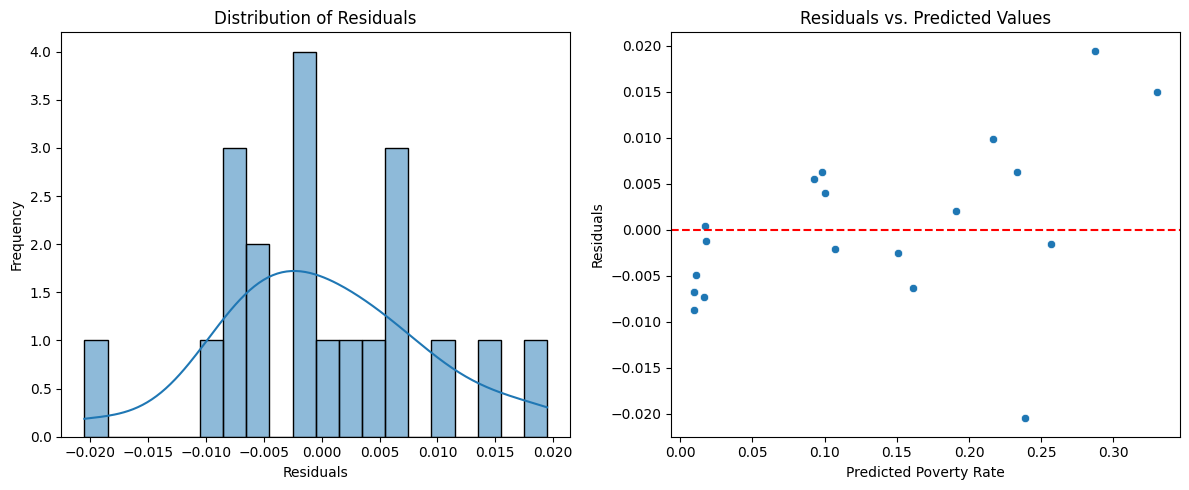


Top 10 instances with largest absolute residuals:


,country,Actual_MPI_poverty_rate,Predicted_MPI_poverty_rate,Residual,Absolute_Residual
5,Benin,0.2185,0.239003,-0.020503,0.020503
6,Burkina Faso,0.3070,0.287521,0.019479,0.019479
13,Bhutan,0.3450,0.330040,0.014960,0.014960
4,Burundi,0.2265,0.216676,0.009824,0.009824
2,Armenia,0.0010,0.009720,-0.008720,0.008720
14,Central African Republic,0.0090,0.016280,-0.007280,0.007280
0,Afghanistan,0.0030,0.009720,-0.006720,0.006720
16,Cameroon,0.0030,0.009720,-0.006720,0.006720
15,China,0.1550,0.161313,-0.006313,0.006313
8,Bosnia and Herzegovina,0.2395,0.233206,0.006294,0.006294


In [38]:
print("--- Error Analysis ---")

# Assuming 'best_model_info_test' and 'best_models_grid'/'best_models' are available from test set evaluation
if 'best_model_info_test' in globals():
    best_model_name = best_model_info_test['Model']
    best_model_search_type = best_model_info_test['Search Type']

    if best_model_search_type == 'Grid Search' and best_model_name in best_models_grid:
        best_model = best_models_grid[best_model_name]
    elif best_model_search_type == 'Random Search' and best_model_name in best_models:
         best_model = best_models[best_model_name]
    else:
        print(f"Error: Best model '{best_model_name}' from '{best_model_search_type}' not found.")
        best_model = None

    if best_model:
        # Calculate predictions on the test set
        y_pred_test = best_model.predict(X_test)

        # Calculate residuals
        residuals = y_test - y_pred_test

        # Visualize Residuals
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(residuals, bins=20, kde=True)
        plt.xlabel("Residuals")
        plt.ylabel("Frequency")
        plt.title("Distribution of Residuals")

        plt.subplot(1, 2, 2)
        sns.scatterplot(x=y_pred_test, y=residuals)
        plt.xlabel("Predicted Poverty Rate")
        plt.ylabel("Residuals")
        plt.title("Residuals vs. Predicted Values")
        plt.axhline(y=0, color='r', linestyle='--')

        plt.tight_layout()
        plt.show()

        # Identify data points with largest absolute residuals
        abs_residuals = np.abs(residuals)
        # Get the original rows corresponding to the test set using the indices from the train-test split
        # The indices of X_test correspond to the indices of X after the split
        original_test_indices = y_test.index if isinstance(y_test, pd.Series) else np.arange(len(y_test)) # Fallback for numpy array
        merged_df_test = merged_df.loc[original_test_indices].copy()

        error_analysis_df = merged_df_test.copy()
        error_analysis_df['Actual_MPI_poverty_rate'] = y_test
        error_analysis_df['Predicted_MPI_poverty_rate'] = y_pred_test
        error_analysis_df['Residual'] = residuals
        error_analysis_df['Absolute_Residual'] = abs_residuals

        error_analysis_df_sorted = error_analysis_df.sort_values(by='Absolute_Residual', ascending=False)

        print("\nTop 10 instances with largest absolute residuals:")
        display(error_analysis_df_sorted[['country', 'Actual_MPI_poverty_rate', 'Predicted_MPI_poverty_rate', 'Residual', 'Absolute_Residual']].head(10))

    else:
        print("Could not perform error analysis: Best model not found.")

else:
    print("Could not perform error analysis: Test set evaluation results ('best_model_info_test') not found.")

### Feature Engineering and Selection with MPI Data

This script prepares the dataset for modeling by scaling numerical data and applying **feature selection based on correlation** to reduce the number of features. The target variable is the MPI-derived `poverty_rate`, and the features include Wikipedia embeddings, GDP per capita, and MPI-related metrics.

**Purpose / Why We Do This:**

* High-dimensional features (e.g., embeddings + economic indicators) can be redundant or noisy.
* Scaling ensures that all features contribute equally to the analysis and downstream models.
* Feature selection based on correlation helps identify and keep only the most relevant features, potentially improving model performance and interpretability.

**Steps Involved:**

1.  **Target Selection:** Use the MPI-derived `poverty_rate` as the response variable.
2.  **Feature Selection (Initial):** Exclude non-numeric or irrelevant columns like `country`, `summary`, original poverty metrics, and the 'ISO' code. Include embeddings, GDP, and relevant MPI-related columns.
3.  **Scaling:** Standardize all features using `StandardScaler` to ensure equal contribution.
4.  **Correlation Analysis and Feature Selection (Refined):** Calculate the absolute correlation of each scaled feature with the target variable. Select the top 20 features with the highest absolute correlation and discard the rest. Explicitly exclude 'MPI Urban' and 'MPI Rural' from this selection process before picking the top features.
5.  **Train-Test Split:** Split the selected and scaled dataset into training and testing sets for modeling, maintaining alignment with the target variable.
6.  **Summary:** Print counts of original features, features after selection, the target variable used, and the shapes of training/testing sets to verify readiness for modeling.

This process ensures the dataset is **relevant, scaled, and ready for machine learning algorithms**.